In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
from pyedflib import highlevel
from bibliotheque import *
import yasa
import tqdm
import mne

In [3]:
root = '/crnldata/'

In [ ]:
input_file = root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_staged.nc'
# input_file = root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/data/190722B-A.edf'

In [5]:
da = xr.load_dataarray(input_file)

In [29]:
chans = list(da.coords['chan'].values)
eeg_chans = ['Fp2-C4','C4-T4','T4-O2','Fz-Cz','Cz-Pz','Fp1-C3','C3-T3','T3-O1']
respi_chan = 'THERM'
ecg_chan = 'ECG'
eog_chans = ['EOGDt-A2','EOGG-A1']
stages = ['W','R','N1','N2','N3']
srate = 256

In [6]:
da

<xarray.DataArray (stage: 5, chan: 31, time: 3924480)>
array([[[ 1.57316828e+01,  1.21813412e+01,  9.38920537e+00, ...,
                     nan,             nan,             nan],
        [ 5.83001757e+01,  5.72083252e+01,  5.58677758e+01, ...,
                     nan,             nan,             nan],
        [-1.19060935e+02, -1.19908883e+02, -1.20117212e+02, ...,
                     nan,             nan,             nan],
        ...,
        [-3.68261630e-01, -3.65724343e-01, -3.68702077e-01, ...,
                     nan,             nan,             nan],
        [ 2.69694168e-01,  2.59228093e-01,  2.38982679e-01, ...,
                     nan,             nan,             nan],
        [ 8.23987182e-02,  8.23987182e-02,  8.23987182e-02, ...,
                     nan,             nan,             nan]],

       [[ 9.72816700e+00,  1.12047267e+01,  1.24118174e+01, ...,
                     nan,             nan,             nan],
        [ 5.09937705e+01,  4.90444414e+01,  4.72933498e+01, ...,
                     nan,             nan,             nan],
        [-6.25459270e+01, -5.86669804e+01, -5.60065717e+01, ...,
                     nan,             nan,             nan],
...
        [-3.63607233e-01, -3.64502465e-01, -3.63720156e-01, ...,
         -3.74177658e-01, -3.74226240e-01, -3.71045281e-01],
        [ 2.86106661e-01,  3.44247424e-01,  2.71594972e-01, ...,
          2.83632792e-01,  2.96872871e-01,  3.02782408e-01],
        [ 8.23987182e-02,  8.23987182e-02,  8.23987182e-02, ...,
          8.23987182e-02,  8.23987182e-02,  8.23987182e-02]],

       [[ 3.82657269e+01,  3.81343494e+01,  3.84238475e+01, ...,
                     nan,             nan,             nan],
        [ 4.57486231e+01,  4.59503743e+01,  4.72195541e+01, ...,
                     nan,             nan,             nan],
        [-6.88179253e+01, -6.79525058e+01, -6.83767988e+01, ...,
                     nan,             nan,             nan],
        ...,
        [-3.69689764e-01, -3.68390807e-01, -3.68480827e-01, ...,
                     nan,             nan,             nan],
        [ 2.35492119e-01,  2.89770504e-01,  2.17274226e-01, ...,
                     nan,             nan,             nan],
        [ 8.23987182e-02,  8.23987182e-02,  8.23987182e-02, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 1.533e+04 1.533e+04
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... '-' 'ANNOTATION'
  * stage    (stage) object 'N2' 'R' 'N3' 'W' 'N1'

In [10]:
da_N2 = da.sel(stage = 'N2').dropna(dim='time')

In [11]:
da_N2

<xarray.DataArray (chan: 31, time: 2903040)>
array([[ 1.57316828e+01,  1.21813412e+01,  9.38920537e+00, ...,
         4.13026381e+01,  4.20410044e+01,  4.21016577e+01],
       [ 5.83001757e+01,  5.72083252e+01,  5.58677758e+01, ...,
         6.90338347e+01,  7.26383614e+01,  7.55347086e+01],
       [-1.19060935e+02, -1.19908883e+02, -1.20117212e+02, ...,
        -7.11896059e+01, -7.09296860e+01, -7.19917447e+01],
       ...,
       [-3.68261630e-01, -3.65724343e-01, -3.68702077e-01, ...,
        -3.75527809e-01, -3.77589380e-01, -3.75654328e-01],
       [ 2.69694168e-01,  2.59228093e-01,  2.38982679e-01, ...,
         3.01306945e-01,  3.82575387e-01,  2.98738856e-01],
       [ 8.23987182e-02,  8.23987182e-02,  8.23987182e-02, ...,
         8.23987182e-02,  8.23987182e-02,  8.23987182e-02]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 1.134e+04 1.134e+04
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... '-' 'ANNOTATION'
    stage    <U2 'N2'

In [16]:
data = da_N2.sel(chan = eeg_chans).values
chan = eeg_chans

In [19]:
# Apply the detection
sp = yasa.spindles_detect(data=data, sf=srate, ch_names=chan, multi_only=False)

# Get the full detection dataframe
all_spindles = sp.summary()  
all_spindles

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,59.062500,59.421875,59.949219,0.886719,50.552506,9.198861,1.681054,0.273213,13.133270,9.0,0.403509,Fp2-C4,0
1,61.679688,62.152344,62.363281,0.683594,45.307265,11.034409,2.248550,0.552724,12.831320,9.0,0.687500,Fp2-C4,0
2,65.433594,65.742188,66.015625,0.582031,44.304907,10.309570,2.206756,0.374857,13.944231,8.0,0.526667,Fp2-C4,0
3,67.644531,67.765625,68.296875,0.652344,48.667588,11.655442,2.139002,0.361876,14.613934,8.0,0.184524,Fp2-C4,0
4,87.617188,87.996094,88.328125,0.710938,50.774271,10.271449,1.864006,0.237175,13.915260,7.0,0.530055,Fp2-C4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,10650.789062,10650.921875,10651.527344,0.738281,53.699516,11.466963,2.057794,0.347915,13.990410,10.0,0.178947,T3-O1,7
3933,10848.859375,10849.191406,10849.449219,0.589844,46.845153,12.360291,2.203372,0.294651,13.509131,8.0,0.559211,T3-O1,7
3934,10881.660156,10882.257812,10882.429688,0.769531,55.876462,12.462484,1.994074,0.287606,13.846079,10.0,0.772727,T3-O1,7
3935,11121.531250,11122.054688,11122.546875,1.015625,50.616274,10.266257,1.963956,0.387135,13.169566,13.0,0.513410,T3-O1,7


In [20]:
sp.summary(grp_chan=True, aggfunc='mean')

,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
C3-T3,583,0.919878,45.466748,9.805004,1.948723,0.418014,14.031468,11.797599,0.479776
C4-T4,621,0.901312,42.199731,9.106379,1.886765,0.407721,14.001285,11.375201,0.493049
Cz-Pz,207,0.761096,37.357596,8.253230,1.771775,0.344973,13.566378,9.589372,0.475509
Fp1-C3,757,0.882446,55.518850,11.881376,2.102293,0.415687,13.557381,11.170410,0.486041
Fp2-C4,746,0.867413,56.097589,12.042181,2.121926,0.413625,13.529778,10.931635,0.493541
Fz-Cz,740,0.897123,50.749517,10.879459,2.036149,0.415330,13.795175,11.524324,0.486514
T3-O1,142,0.752916,57.477996,12.362736,2.106877,0.334397,13.811340,9.584507,0.512095
T4-O2,141,0.761940,57.862052,12.639071,2.135209,0.339163,13.903804,9.730496,0.514233


<AxesSubplot:title={'center':'Average spindle'}, xlabel='Time (sec)', ylabel='Amplitude (uV)'>

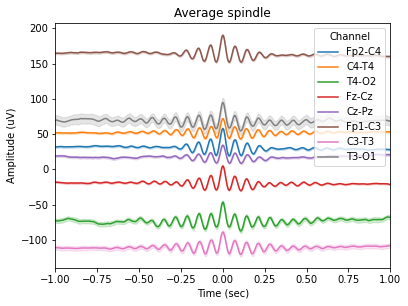

In [21]:
sp.plot_average(center='Peak', time_before=1, time_after=1)

In [23]:
sp_multi = yasa.spindles_detect(data=data, sf=srate, ch_names=chan, multi_only=True, remove_outliers=True)
all_spindles = sp_multi.summary()
print(all_spindles.shape[0], 'spindles detected that are common to at least two electrodes.')
all_spindles.head().round(3)

2793 spindles detected that are common to at least two electrodes.


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,61.680,62.152,62.363,0.684,45.307,11.034,2.249,0.553,12.831,9.0,0.688,Fp2-C4,0
1,65.434,65.742,66.016,0.582,44.305,10.310,2.207,0.375,13.944,8.0,0.527,Fp2-C4,0
2,67.645,67.766,68.297,0.652,48.668,11.655,2.139,0.362,14.614,8.0,0.185,Fp2-C4,0
3,114.316,114.816,115.270,0.953,70.634,14.186,2.372,0.417,14.718,13.0,0.522,Fp2-C4,0
4,117.934,118.441,118.703,0.770,74.880,12.609,2.055,0.326,14.635,10.0,0.657,Fp2-C4,0


In [24]:
sp.summary(grp_chan=True)

,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
C3-T3,583,0.919878,45.466748,9.805004,1.948723,0.418014,14.031468,11.797599,0.479776
C4-T4,621,0.901312,42.199731,9.106379,1.886765,0.407721,14.001285,11.375201,0.493049
Cz-Pz,207,0.761096,37.357596,8.253230,1.771775,0.344973,13.566378,9.589372,0.475509
Fp1-C3,757,0.882446,55.518850,11.881376,2.102293,0.415687,13.557381,11.170410,0.486041
Fp2-C4,746,0.867413,56.097589,12.042181,2.121926,0.413625,13.529778,10.931635,0.493541
Fz-Cz,740,0.897123,50.749517,10.879459,2.036149,0.415330,13.795175,11.524324,0.486514
T3-O1,142,0.752916,57.477996,12.362736,2.106877,0.334397,13.811340,9.584507,0.512095
T4-O2,141,0.761940,57.862052,12.639071,2.135209,0.339163,13.903804,9.730496,0.514233


In [25]:
from functools import reduce
grp_start = all_spindles.groupby('Channel')['Start'].apply(lambda x: list(np.round(x).astype(int))).to_dict()
grp_end = all_spindles.groupby('Channel')['End'].apply(lambda x: list(np.round(x).astype(int))).to_dict()

intersect_start = reduce(np.intersect1d, (grp_start[c] for c in all_spindles['Channel'].unique()))
intersect_end = reduce(np.intersect1d, (grp_end[c] for c in all_spindles['Channel'].unique()))

idx_start = np.in1d(all_spindles['Start'].round().astype(int), intersect_start)
idx_end = np.in1d(all_spindles['End'].round().astype(int), intersect_end)
idx_good = np.logical_or(idx_start, idx_end)

# Now we keep only these spindles in the dataframe
print(all_spindles[idx_good].shape[0], 'unique spindles are common across ALL channels.')
all_spindles[idx_good].head().round(3)

16 unique spindles are common across ALL channels.


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
153,4377.172,4377.375,4378.223,1.051,35.877,8.470,1.786,0.345,13.980,13.0,0.193,Fp2-C4,0
171,4779.766,4780.016,4780.699,0.934,52.706,11.300,2.207,0.582,14.198,12.0,0.267,Fp2-C4,0
627,4377.102,4377.691,4378.277,1.176,37.377,8.488,1.877,0.417,14.113,15.0,0.500,C4-T4,1
640,4779.617,4780.117,4780.707,1.090,51.638,11.321,2.125,0.521,14.274,14.0,0.457,C4-T4,1
978,4376.941,4377.230,4377.785,0.844,60.511,13.867,2.302,0.469,13.971,11.0,0.341,T4-O2,2


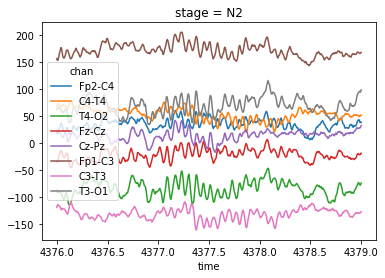

In [28]:
da_N2.loc[eeg_chans , 4376:4379].plot.line(x='time' , hue = 'chan')

In [45]:
def nspindle_by_stage(da_all, stages=stages, chan=eeg_chans, srate=srate):
    rows = []
    for stage in stages:
        da_stage = da_all.sel(stage=stage, chan = chan).dropna(dim='time')
        tot_time_stage = da_stage.coords['time'].values[-1]
        data = da_stage.values
        # Apply the detection
        sp = yasa.spindles_detect(data=data, sf=srate, ch_names=chan, multi_only=False)

        # Get the full detection dataframe
        all_spindles = sp.summary()  
        
        grp_start = all_spindles.groupby('Channel')['Start'].apply(lambda x: list(np.round(x).astype(int))).to_dict()
        grp_end = all_spindles.groupby('Channel')['End'].apply(lambda x: list(np.round(x).astype(int))).to_dict()

        intersect_start = reduce(np.intersect1d, (grp_start[c] for c in all_spindles['Channel'].unique()))
        intersect_end = reduce(np.intersect1d, (grp_end[c] for c in all_spindles['Channel'].unique()))

        idx_start = np.in1d(all_spindles['Start'].round().astype(int), intersect_start)
        idx_end = np.in1d(all_spindles['End'].round().astype(int), intersect_end)
        idx_good = np.logical_or(idx_start, idx_end)

        # Now we keep only these spindles in the dataframe
        nspindles_in_whole_brain = all_spindles[idx_good].shape[0]
        nspindles_all = all_spindles.shape[0]
        
        row = [ stage, nspindles_all , nspindles_in_whole_brain , int(tot_time_stage)]
        rows.append(row)
    df = pd.DataFrame(rows, columns = ['stage' , 'tot spindles found', 'tot common spindles' , 'total time sig'])
    return df

In [46]:
df = nspindle_by_stage(da_all=da)

27-Apr-22 15:08:20 | WARNING | No spindle were found in channel Fp2-C4.
27-Apr-22 15:08:20 | WARNING | No spindle were found in channel C4-T4.
27-Apr-22 15:08:20 | WARNING | No spindle were found in channel T4-O2.
27-Apr-22 15:08:20 | WARNING | No spindle were found in channel Cz-Pz.
27-Apr-22 15:08:20 | WARNING | No spindle were found in channel C3-T3.
27-Apr-22 15:08:20 | WARNING | No spindle were found in channel T3-O1.
27-Apr-22 15:08:43 | WARNING | No spindle were found in channel T4-O2.
27-Apr-22 15:08:44 | WARNING | No spindle were found in channel Cz-Pz.
27-Apr-22 15:08:45 | WARNING | No spindle were found in channel T3-O1.


In [47]:
df

,stage,tot spindles found,tot common spindles,total time sig
0,W,204,0,15329
1,R,27,0,2159
2,N1,2,2,59
3,N2,3937,136,11339
4,N3,75,0,2819


Spindles ++ en N2 , et ce même en proportion sur le temps de signal

In [53]:
da_to_study = da.sel(stage = 'N2').dropna(dim='time')

In [54]:
da_to_study

<xarray.DataArray (chan: 31, time: 2903040)>
array([[ 1.57316828e+01,  1.21813412e+01,  9.38920537e+00, ...,
         4.13026381e+01,  4.20410044e+01,  4.21016577e+01],
       [ 5.83001757e+01,  5.72083252e+01,  5.58677758e+01, ...,
         6.90338347e+01,  7.26383614e+01,  7.55347086e+01],
       [-1.19060935e+02, -1.19908883e+02, -1.20117212e+02, ...,
        -7.11896059e+01, -7.09296860e+01, -7.19917447e+01],
       ...,
       [-3.68261630e-01, -3.65724343e-01, -3.68702077e-01, ...,
        -3.75527809e-01, -3.77589380e-01, -3.75654328e-01],
       [ 2.69694168e-01,  2.59228093e-01,  2.38982679e-01, ...,
         3.01306945e-01,  3.82575387e-01,  2.98738856e-01],
       [ 8.23987182e-02,  8.23987182e-02,  8.23987182e-02, ...,
         8.23987182e-02,  8.23987182e-02,  8.23987182e-02]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 1.134e+04 1.134e+04
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... '-' 'ANNOTATION'
    stage    <U2 'N2'

In [62]:
def spindles_from_stage(da, stage, srate=srate, chan = eeg_chans, save=False):  
    data = da.sel(stage = stage, chan = chan).dropna(dim='time').values
    
    # Apply the detection
    sp = yasa.spindles_detect(data=data, sf=srate, ch_names=chan, multi_only=False)

    # Get the full detection dataframe
    all_spindles = sp.summary()  
    all_spindles.insert(0 , 'stage', stage)
    if save: 
        spindles.to_excel(root + f'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/df_analyse/spindles_{stage}.xlsx')
    return all_spindles

In [64]:
spindles = spindles_from_stage(da=da, stage = 'N2', save=False)

In [60]:
spindles

,stage,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,N2,59.062500,59.421875,59.949219,0.886719,50.552506,9.198861,1.681054,0.273213,13.133270,9.0,0.403509,Fp2-C4,0
1,N2,61.679688,62.152344,62.363281,0.683594,45.307265,11.034409,2.248550,0.552724,12.831320,9.0,0.687500,Fp2-C4,0
2,N2,65.433594,65.742188,66.015625,0.582031,44.304907,10.309570,2.206756,0.374857,13.944231,8.0,0.526667,Fp2-C4,0
3,N2,67.644531,67.765625,68.296875,0.652344,48.667588,11.655442,2.139002,0.361876,14.613934,8.0,0.184524,Fp2-C4,0
4,N2,87.617188,87.996094,88.328125,0.710938,50.774271,10.271449,1.864006,0.237175,13.915260,7.0,0.530055,Fp2-C4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,N2,10650.789062,10650.921875,10651.527344,0.738281,53.699516,11.466963,2.057794,0.347915,13.990410,10.0,0.178947,T3-O1,7
3933,N2,10848.859375,10849.191406,10849.449219,0.589844,46.845153,12.360291,2.203372,0.294651,13.509131,8.0,0.559211,T3-O1,7
3934,N2,10881.660156,10882.257812,10882.429688,0.769531,55.876462,12.462484,1.994074,0.287606,13.846079,10.0,0.772727,T3-O1,7
3935,N2,11121.531250,11122.054688,11122.546875,1.015625,50.616274,10.266257,1.963956,0.387135,13.169566,13.0,0.513410,T3-O1,7
